# 4D-STEM Simulations

## Teil 1
AbTem installieren, Data checken und Atomare Zahl korrigiert 

In [1]:
!pip install --upgrade abtem[all]

In [68]:
import ase.io
import matplotlib.pyplot as plt
import numpy as np
import abtem
from nexus import save_array_as_nxs

loading the MD trajectory from file and find out how many MD time steps there are.

In [69]:
trj = ase.io.read('trj.zr50cu50_6750_vib',format='lammps-dump-text',index='::1')
Nslice = len(trj)
Natoms = len(trj[0].arrays['numbers'])
print(f"Number of slices in the file: {Nslice}")
print(f"Number of atoms in structure: {Natoms}")
dt_fs = 50  # time step is 50 fs
beam_energy_kV = 200
max_angle_mrad = 80

Number of slices in the file: 101
Number of atoms in structure: 6750


ploting the x,y-trajectory of atom 513. This helps us to see, how a single atoms move during the time of the simulation.

In [70]:
iatom = 513
# create empty arrays for position coordinates x,y,z, and the atomic numbe Z
x = np.zeros(Nslice)
y = np.zeros(Nslice)
z = np.zeros(Nslice)
Z = np.zeros(Nslice)
# Now let's loop through all slices of the trajectory and extract the coordinates and Z-number of atom iatom from each of the slices:
for j in range(Nslice):
    x[j] = trj[j].arrays['positions'][iatom,0]
    y[j] = trj[j].arrays['positions'][iatom,1]
    z[j] = trj[j].arrays['positions'][iatom,2]
    Z[j] = trj[j].arrays['numbers'][iatom]

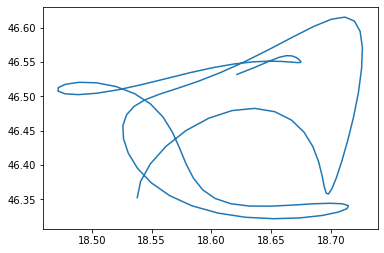

In [71]:
plt.plot(x,y)

Since the Z-numbers are 1 and 2, we need to convert them to the actual Z-numbers Zr [40] and Cu [29].

In [3]:
atom_types = np.array([0,40,29])
for j in range(Nslice):
    # in case the Z-numbers have already been converted, we first check:
    if trj[j].arrays['numbers'][0] < len(atom_types):
        trj[j].arrays['numbers'] = atom_types[trj[j].arrays['numbers']]

Since some atoms have jumped into neighboring unit cells, we must move them back.

In [5]:
lim = 0.3*trj[0].cell[0][0]
for j in range(1,Nslice):
    for coord in range(3):
        # correct x,y,z-coordinates:
        atms = np.argwhere(trj[j].arrays['positions'][:,coord]-trj[j-1].arrays['positions'][:,coord] > lim)
        trj[j].arrays['positions'][atms,coord] -= trj[j].cell[coord][coord]                   
        atms = np.argwhere(trj[j].arrays['positions'][:,coord]-trj[j-1].arrays['positions'][:,coord] < -lim)
        trj[j].arrays['positions'][atms,coord] += trj[j].cell[coord][coord]  

Now, let's check if the super cell around the atoms is constant wit time. This information is contained in the cell size along x,y, and z.

Cell[0] Cell([49.105089847192154, 49.105089847192154, 49.105089847192154])
Cell[end] Cell([49.12263334733477, 49.12263334733477, 49.12263334733477])


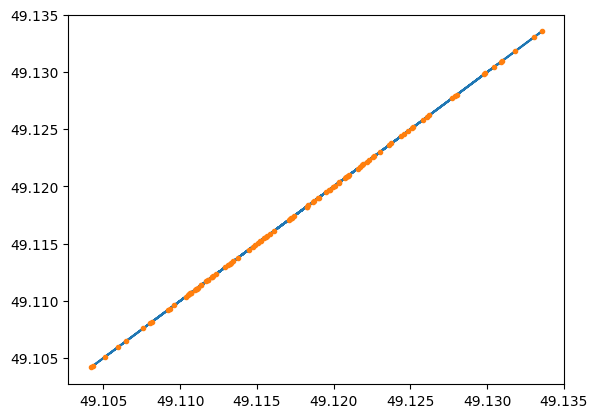

In [6]:
for j in range(Nslice):
    x[j] = trj[j].cell[0][0]
    y[j] = trj[j].cell[1][1]
    z[j] = trj[j].cell[2][2]

plt.plot(x,y)
plt.plot(x,z,'.')
print('Cell[0]',trj[0].cell)
print('Cell[end]',trj[-1].cell)

Aus dem obigen Plot sehen wir, dass die Superzelle mit den Atomen darin mit der Zeit wächst. Das liegt vermutlich daran, dass diese 'Bounding Box' nur die Differenz zwischen kleinster und größter Koordinate angibt. Wir ersetzen daher alle Zellen durch die größte Zelle von allen.

In [74]:
max_index = np.argmax(x)
print('largest x-size of bounding box for frame',max_index)
cell_max = trj[max_index].cell
for j in range(Nslice):
    trj[j].cell = cell_max

largest x-size of bounding box for frame 76


To measure the displacement of all the atoms in all three dimensions we first produce a mean structure, were all the positions are averaged in time.

In [75]:
mean_structure = trj[0].copy()
for j in range(1,Nslice):
    mean_structure.arrays['positions'] += trj[j].arrays['positions']
mean_structure.arrays['positions'] /= Nslice

Text(0, 0.5, 'standard deviation in A')

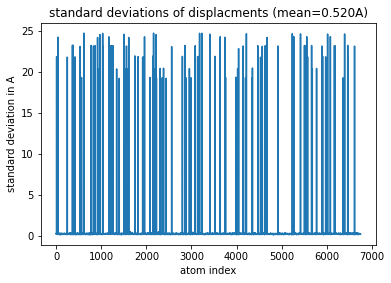

In [76]:
std_structure = np.zeros(Natoms)
for j in range(Nslice):
    std_structure += np.sum((mean_structure.arrays['positions'] - trj[j].arrays['positions'])**2,1)
std_structure /= Nslice-1
std_structure = np.sqrt(std_structure)
plt.plot(std_structure)
sigma = np.mean(std_structure)
plt.title(f"standard deviations of displacments (mean={sigma:.3f}A)") 
plt.xlabel('atom index')
plt.ylabel('standard deviation in A')

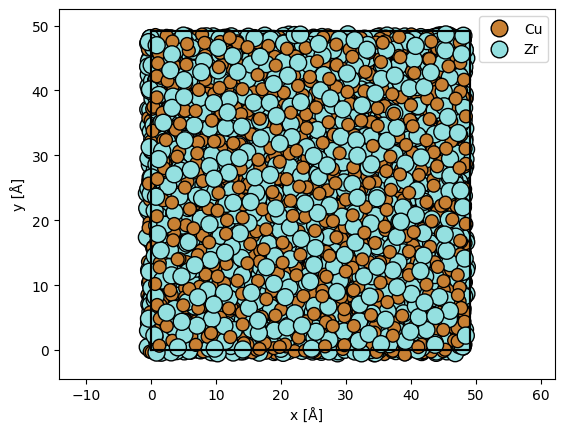

In [9]:
abtem.show_atoms(mean_structure, plane="xy", legend=True);

## Teil 2: Simulationen

In [12]:
pip install "numpy<2.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 72.8 MB/s eta 0:00:0000:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ptyrad 0.1.0b7 requires torch<2.7,>=2.0, which is not installed.
accelerate 1.7.0 requires torch>=2.0.0, which is not installed.
torchvision 0.20.1+cu121 requires torch==2.5.1, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [10]:
%config InlineBackend.rc = {"figure.dpi": 72, "figure.figsize": (6.0, 4.0)}
%matplotlib inline

import abtem
import ase
import matplotlib.pyplot as plt
from ase.io import write

Erste Simulation mit scan_shape 64*64

In [15]:
import os
import numpy as np
from ase.io import read
import matplotlib.pyplot as plt
from abtem import Potential, Probe
from abtem.detectors import PixelatedDetector
from tqdm import tqdm
from abtem.scan import GridScan

# ----- Parameter -----
beam_energy = 200e3               # eV
convergence_angle = 40         # rad  ### Commment from anton, this should be mrad, not rad!!!!!!!!!!!! I changed 40e-3 to 40!!!!!!!
sampling = 0.1                    # Angstrom
scan_shape = (64, 64)             # Rastergröße: 64x64 Punkte
detector_shape = (256, 256)       # Auflösung des Detektors
output_dir = 'results_4dstem'
os.makedirs(output_dir, exist_ok=True)

# ----- Lade und korrigiere Trajektorie -----
trj = read('trj.zr50cu50_6750_vib', format='lammps-dump-text', index='::10')

# ----- Haupt-Simulation -----
diffraction_stack = []

for i, atoms in enumerate(tqdm(trj, desc="Simulating 4D-STEM frames")):
    potential = Potential(atoms, sampling=sampling)

    probe = Probe(
        energy=beam_energy,
        semiangle_cutoff=convergence_angle,
        sampling=potential.sampling
    )

    #  Erzeuge Scanpositionen
    y = np.linspace(0, potential.extent[0], scan_shape[0])
    x = np.linspace(0, potential.extent[1], scan_shape[1])
    yy, xx = np.meshgrid(y, x, indexing='ij')
    positions = np.stack((yy.ravel(), xx.ravel()), axis=-1)
    scan = GridScan(
    start=(0.0, 0.0),
    end=potential.extent,  # physical size of the simulation cell
    gpts=scan_shape        # number of scan points in each direction
    )

    #  Detektor definieren
    detector = PixelatedDetector(max_angle=80, resample="uniform") ### Added by Anton: max_angle = 80 mrad, 

    #  Simuliere 4D-STEM
    pattern = probe.scan(potential=potential, scan=scan, detectors=detector)
    pattern_array = pattern.array.compute()

    #  Umformen zu (scan_y, scan_x, q_y, q_x)
    frame_4d = pattern_array.reshape(scan_shape + pattern_array.shape[-2:])
    diffraction_stack.append(frame_4d)

# ----- Speichern -----
stack_4d = np.stack(diffraction_stack)
np.save(os.path.join(output_dir, '4dstem_stack.npy'), stack_4d)
print(f" DONE: 4D-STEM stack saved with shape {stack_4d.shape}")

Simulating 4D-STEM frames: 100%|██████████| 11/11 [2:31:10<00:00, 824.61s/it] 


 DONE: 4D-STEM stack saved with shape (11, 64, 64, 316, 316)


In [15]:
50/64

0.78125

Reale Dimension x,y

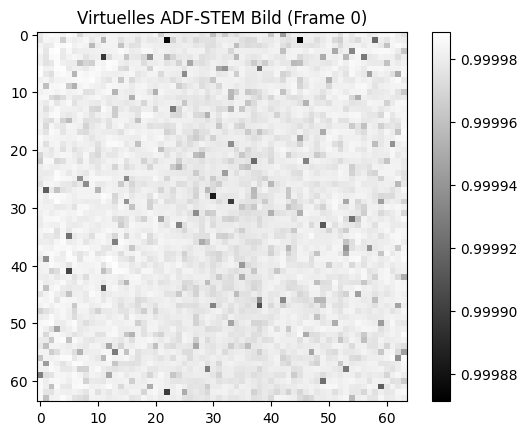

In [10]:
import numpy as np
import matplotlib.pyplot as plt

stack = np.load('results_4dstem/4dstem_stack.npy')  
adf_image = stack[0].sum(axis=(-2, -1))  # Summe über qy, qx

plt.imshow(adf_image, cmap='gray')
plt.title('Virtuelles ADF-STEM Bild (Frame 0)')
plt.colorbar()
plt.show()

Beugung

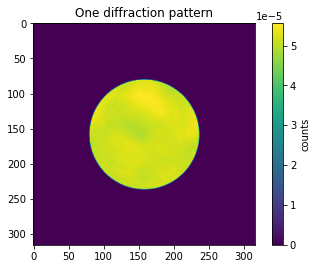

In [17]:
plt.imshow(stack[0,2,1])
plt.title("One diffraction pattern")
cbar=plt.colorbar()
cbar.set_label("counts")
plt.show()

In [18]:
measurements = probe.scan(potential, scan=scan, detectors=detector)

In [19]:
print(measurements.shape)  # Should be (64, 64, q_y, q_x)

(64, 64, 316, 316)


Center of Mass

[########################################] | 100% Completed | 13m 52s


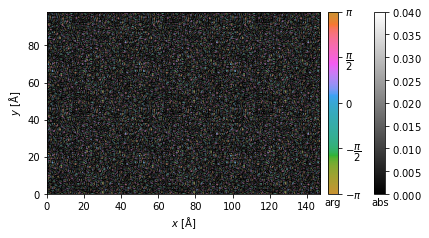

In [20]:
filtered = measurements.gaussian_source_size(0.3)
com = filtered.center_of_mass()
com.interpolate(0.05).tile((3, 2)).show(cbar=True, vmax=0.04, vmin=0)

In [24]:
image_array = np.abs(com.interpolate(0.05).tile((3, 2)).array.compute())

In [26]:
plt.imsave('com_tile_highres.png', image_array, cmap='viridis', dpi=1000)

## Comments from Anton, 11.07.2025

Okay, this looks already alright. Now to an actual simulation: you save the frames as a stack, you should sum them over the first axis, so 
dataset=stack_4d.sum(0)
Then you should reshape the data in a following way:

dataset=np.swapaxes(np.swapaxes(dataset,0,1),2,3)[::-1,:,::-1,:]

this three operations convert abtem-style axes directions into the convention we will further use in data analysis (pythonic convention). Then we have to find out parameters.

# now bin the data by 2
dataset_shape=dataset.shape
dataset_shape_ky, dataset_shape_kx=dataset_shape[2], dataset_shape[3]
dataset=(dataset[:,:,:2*(dataset_shape_ky//2), :2*(dataset_shape_kx//2)]).reshape(dataset_shape[0], dataset_shape[1],(dataset_shape_ky//2), 2, (dataset_shape_kx//2),2).sum((3,5))

You do these operations after simulation. Now a bit more on the simulation it self.

I would propose to do 100 scan steps in both directions, so you should have roughly 0.5 Å scan step. Then we might want to reduce the convergence angle to 30 mrad and collection angle to 80 mrad. Further you want to defocus the beam slightly. -100 Å defocus should work just fine. Please make this adjustments to simulations and generate a dataset with this parameters. 






In [28]:
import numpy as np
from ase.io import read
import matplotlib.pyplot as plt
from abtem import Potential, Probe
from abtem.detectors import PixelatedDetector
from abtem.scan import GridScan
from tqdm import tqdm

# ----- Parameter -----
beam_energy = 200e3               # eV
convergence_angle = 30            # mrad
sampling = 0.1                    # Angstrom
scan_shape = (100, 100)             # Changed scan from (64, 64) to (100, 100), This gives a scan step of approximately 0.5 Å,
detector_shape = (256, 256)       # Auflösung des Detektors
defocus = -100                    # in Å
output_dir = 'results_4dstem_correction'
os.makedirs(output_dir, exist_ok=True)

# ----- Lade und korrigiere Trajektorie -----
trj = read('trj.zr50cu50_6750_vib', format='lammps-dump-text', index='::10')

# ----- Haupt-Simulation -----
diffraction_stack = []

for i, atoms in enumerate(tqdm(trj, desc="Simulating 4D-STEM frames")):
    potential = Potential(atoms, sampling=sampling)

    probe = Probe(
        energy=beam_energy,
        semiangle_cutoff=convergence_angle,
        sampling=potential.sampling,
        defocus=-100  # defocus in Å
    )

    #  Erzeuge Scanpositionen
    y = np.linspace(0, potential.extent[0], scan_shape[0])
    x = np.linspace(0, potential.extent[1], scan_shape[1])
    yy, xx = np.meshgrid(y, x, indexing='ij')
    positions = np.stack((yy.ravel(), xx.ravel()), axis=-1)
    scan = GridScan(
    start=(0.0, 0.0),
    end=potential.extent,  # physical size of the simulation cell
    gpts=scan_shape        # number of scan points in each direction
    )

    #  Detektor definieren
    detector = PixelatedDetector(max_angle=80, resample="uniform")

    #  Simuliere 4D-STEM
    pattern = probe.scan(potential=potential, scan=scan, detectors=detector)
    pattern_array = pattern.array.compute()

    #  Umformen zu (scan_y, scan_x, q_y, q_x)
    frame_4d = pattern_array.reshape(scan_shape + pattern_array.shape[-2:])
    diffraction_stack.append(frame_4d)

# ----- Speichern -----
stack_4d = np.stack(diffraction_stack)
np.save(os.path.join(output_dir, '4dstem_stack.npy'), stack_4d)
print(f" DONE: 4D-STEM stack saved with shape {stack_4d.shape}")

Simulating 4D-STEM frames: 100%|██████████| 11/11 [6:13:59<00:00, 2039.93s/it] 


 DONE: 4D-STEM stack saved with shape (11, 100, 100, 316, 316)


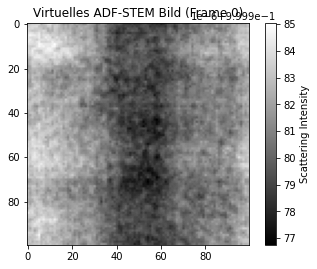

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Load your simulated stack
stack = np.load('results_4dstem_correction/4dstem_stack.npy')

# Sum over diffraction axes to get virtual ADF-STEM image
adf_image = stack[0].sum(axis=(-2, -1))  # Frame 0

# Plot with labels and color bar
plt.imshow(adf_image, cmap='gray')
plt.title('Virtuelles ADF-STEM Bild (Frame 0)')
cbar = plt.colorbar()
cbar.set_label('Scattering Intensity')  # ← Farbskalen-Beschriftung
plt.show()

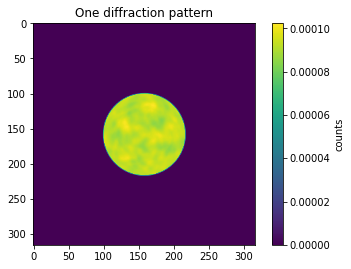

In [39]:
plt.imshow(stack[0,2,1])
plt.title("One diffraction pattern")
cbar=plt.colorbar()
cbar.set_label("counts")
plt.show()

In [29]:
dataset = stack_4d.sum(0)  

In [32]:
dataset=np.swapaxes(np.swapaxes(dataset,0,1),2,3)[::-1,:,::-1,:]

In [34]:
dataset_shape = dataset.shape
dataset_shape_ky, dataset_shape_kx = dataset_shape[2], dataset_shape[3]
dataset_cropped = dataset[:, :, :2*(dataset_shape_ky//2), :2*(dataset_shape_kx//2)]

# Reshape for 2× binning in q-space
dataset_binned = dataset_cropped.reshape(
    dataset_shape[0], dataset_shape[1],
    dataset_shape_ky // 2, 2,
    dataset_shape_kx // 2, 2
).sum(axis=(3, 5))

## save dataset

In [59]:
import numpy as np
np.save('results_4dstem_correction/4dstem_binned.npy',dataset_binned)

In [61]:
print(potential.extent)

(49.105089847192154, 49.105089847192154)


In [63]:
print(atoms.cell)  # This shows the full simulation box

Cell([49.105089847192154, 49.105089847192154, 49.105089847192154])
